2025-02-15 20:45:55.629687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-15 20:45:55.630358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 20:45:55.635613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-15 20:45:55.650644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739623555.671647   12031 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739623555.67

Null values in each column:
 Price        Ticker
Close        AAPL      0
High         AAPL      0
Low          AAPL      0
Open         AAPL      0
Volume       AAPL      0
20MA                   0
50MA                   0
200MA                  0
RSI                    0
12EMA                  0
26EMA                  0
MACD                   0
Signal_Line            0
dtype: int64
Does the dataset contain any null values? False
Epoch 1/10


2025-02-15 20:45:59.111553: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0407 - val_loss: 0.0132
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0030 - val_loss: 0.0135
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0022 - val_loss: 0.0095
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0015 - val_loss: 0.0109
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0013 - val_loss: 0.0145
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0011 - val_loss: 0.0083
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0013 - val_loss: 0.0055
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032
Test loss: 0.005398547742515802
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Root Mean Square Error (RMSE): 10

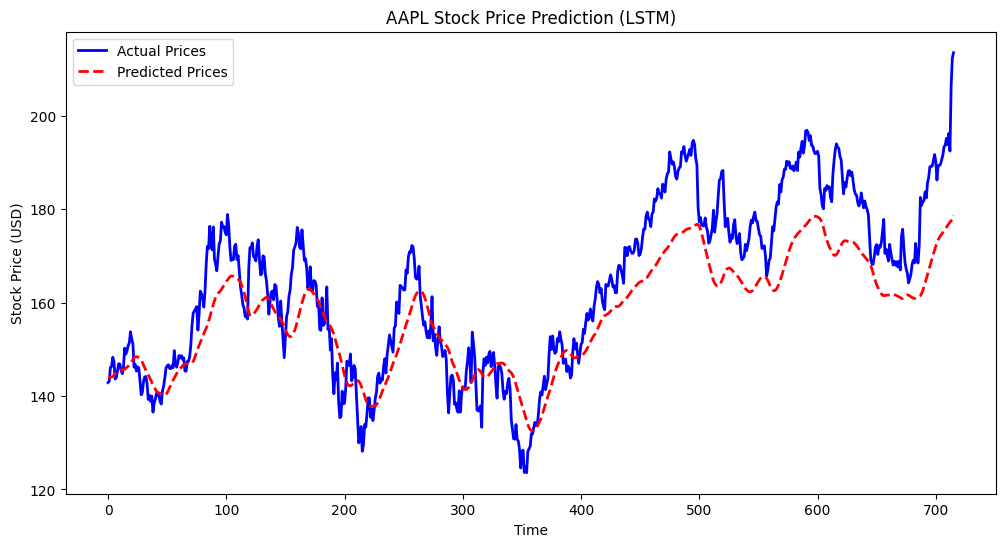

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (0 = all logs, 1 = INFO, 2 = WARNINGS, 3 = ERRORS)
tf.get_logger().setLevel('ERROR')  # Suppress warnings and info logs

# Download stock data
def download_stock_data(ticker, start_date='2010-01-01', end_date='2024-06-14'):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Create technical indicators
def add_technical_indicators(df):
    # Moving Averages
    df['20MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['50MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200MA'] = df['Close'].rolling(window=200, min_periods=1).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.loc[:, 'RSI'] = df['RSI'].fillna(50)


    # MACD
    df['12EMA'] = df['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    df['26EMA'] = df['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()

    # Fill any remaining NaN values
    df.ffill(inplace=True)  # Forward fill
    df.bfill(inplace=True)  # Backward fill

    # Verify no NaN values exist
    print("Null values in each column:\n", df.isnull().sum())
    print(f"Does the dataset contain any null values? {df.isnull().values.any()}")

    return df

# Normalize the data
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', '20MA', '50MA', '200MA', 'RSI', 'MACD']])
    return scaled_data, scaler

# Prepare the time-series data
def create_time_series_data(df, scaled_data, window_size=60):
    X = []
    y = []
    
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i])  # Previous 'window_size' rows
        y.append(df['Close'].iloc[i])  # Target is the next day's closing price

    X = np.array(X)
    y = np.array(y)

    return X, y

# Split the data into training and testing sets
def split_data(X, y, test_size=0.2):
    train_size = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test

# Create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # LSTM Layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Fully connected output layer
    model.add(Dense(units=1))  # Predicting one value (the next day's closing price)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Example usage
ticker = 'AAPL'
df = download_stock_data(ticker)
df = add_technical_indicators(df)

scaled_data, scaler = normalize_data(df)

# Create time-series data (60 days of features to predict the next day's closing price)
X, y = create_time_series_data(df, scaled_data)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = split_data(X, y)

# Normalize target values as well
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Define input shape based on X_train
input_shape = (X_train.shape[1], X_train.shape[2])

# Create model
model = create_lstm_model(input_shape)

# Add EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_test, y_test_scaled), callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test_scaled)
print(f"Test loss: {loss}")

# Make predictions on the test data
predictions = model.predict(X_test)

# Rescale predictions back to the original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Rescale actual test values back to the original scale
y_test_original = scaler.inverse_transform(y_test_scaled)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")


import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Prices", color="blue", linewidth=2)
plt.plot(predictions, label="Predicted Prices", color="red", linestyle="dashed", linewidth=2)
plt.title(f"{ticker} Stock Price Prediction (LSTM)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
